# Assignment 2

Import libraries: The libraries being used are NumPy, pandas, matplotlib, and sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import root_mean_squared_error

# Abalone Dataset Preprocessing

In [2]:
#Load dataset
abalone_columns = ["Sex", "Length","Diameter", "Height", "Whole_weight", "Shucked_weight","Viscera_weight","Shell_weight","Rings"]
abalone = pd.read_csv("abalone.csv",  header = None, names = abalone_columns)

numerical_features = ["Length","Diameter", "Height", "Whole_weight", "Shucked_weight","Viscera_weight","Shell_weight"]
categorical_features = ["Sex"]

#Convert categorical column to one-hot
abalone = pd.get_dummies(abalone, columns = ["Sex"], dtype = "int")

In [3]:
#Split into train and test set
X_1 = abalone.drop("Rings", axis = 1)
y_1 = abalone["Rings"]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, train_size = 0.8, random_state = 10)

# Wine Dataset Preprocessing

In [4]:
#Loading Data set
wine_r = pd.read_csv("winequality-red.csv", sep=';')
#Loading Data set
wine_w = pd.read_csv("winequality-white.csv", sep=';')
wine_w= wine_w.copy()

# adding color info as a column
C = 'color'
wine_w[C]= np.zeros(wine_w.shape[0])
wine_r[C]= np.ones(wine_r.shape[0])

# join the dataframes
datasets = [wine_r, wine_w]
wine_data = pd.concat(datasets)

X = wine_data.drop(columns=['quality'])
y = wine_data['quality']

# Train-test split
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Forest Fires Dataset Preprocessing

In [5]:
#Load forest fires dataset
forest_fires = pd.read_csv("forestfires.csv")
forestfire_numerical_features = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

#check for missing values
#forest_fires.isnull().sum()

#One hot encode the categorical columns
forest_fires = pd.get_dummies(forest_fires, columns = ["month", "day"], dtype = "int")

#Preprocessing without transforming the area column
#Split into train and test set
forestfire_X1 = forest_fires.drop("area", axis = 1)
forestfire_y1 = forest_fires["area"]

forestfire_X_train1, forestfire_X_test1, forestfire_y_train1, forestfire_y_test1 = train_test_split(forestfire_X1, forestfire_y1,
                                                                              train_size = 0.8, random_state = 10)

In [6]:
#Preprocessing with transforming the area column
#Transform the area column
forest_fires["area"] = np.log(forest_fires["area"]+1)

#Split into train and test set
forestfire_X = forest_fires.drop("area", axis = 1)
forestfire_y = forest_fires["area"]

forestfire_X_train, forestfire_X_test, forestfire_y_train, forestfire_y_test = train_test_split(forestfire_X, forestfire_y,
                                                                              train_size = 0.8, random_state = 10)

# Part 2 - Regression

### Abalone Data Regression

In [7]:
#Reference used: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html [1]

#Pipeline for preprocessing abalone data
numeric_transformer = Pipeline([("scaler", StandardScaler())])
transformer = ColumnTransformer(transformers = [("numeric", numeric_transformer, numerical_features)])

In [8]:
abalone_knn_pipeline = Pipeline(steps = [("transformer", transformer),("knn", KNeighborsRegressor())])
abalone_rf_pipeline = Pipeline(steps = [("transformer", transformer),("rf", RandomForestRegressor(random_state = 42))])
abalone_gtb_pipeline = Pipeline(steps = [("transformer", transformer),("gtb", GradientBoostingRegressor(random_state = 42))])

#K-Nearest Neighbours Model
#Hyperparameter tuning with grid search
knn_parameters = {"knn__n_neighbors":[i for i in range(1,21)], "knn__weights":["uniform","distance"]}
knn_gridsearch = GridSearchCV(abalone_knn_pipeline, param_grid = knn_parameters, scoring='neg_mean_squared_error', cv = 5)

#Random Forest Model
#Hyperparameter tuning with grid search
rf_parameters = {"rf__n_estimators": [i for i in range(3, 50, 10)] , "rf__max_depth": [j for j in range(2,10)]}
rf_gridsearch = GridSearchCV(abalone_rf_pipeline, param_grid = rf_parameters,scoring='neg_mean_squared_error', cv = 5)

#Gradient Tree Boosting Model
#Hyperparameter Tuning:
gtb_parameters = {"gtb__n_estimators": [i for i in range(3, 50, 10)] , "gtb__max_depth": [j for j in range(2,10)]}
gtb_gridsearch = GridSearchCV(abalone_gtb_pipeline, param_grid = gtb_parameters, scoring='neg_mean_squared_error', cv = 5)

models = [knn_gridsearch, rf_gridsearch, gtb_gridsearch]
for model in models:
    #Fit the training data to the grid search cross validation for each model
    model.fit(X = X_train_1 , y = y_train_1)

In [9]:
model_names = ["knn", "random_forest", "gradient_tree_boosting"]
abalone_rmse_results = {}

for i, model in enumerate(models):
    #Get the test result using the model with best found parameters
    y_pred = model.predict(X_test_1)
    rmse_val = root_mean_squared_error(y_true = y_test_1, y_pred = y_pred)
    abalone_rmse_results[model_names[i]] = rmse_val

    print("Regression results for model ", model_names[i],": ")
    print("Best parameter combination: ", model.best_params_)
    print("Mean cross validation test score of best estimator: ", model.best_score_)
    print("Variance of cross validation test score of best estimator:", (model.cv_results_["std_test_score"][model.best_index_])**2 )
    print("RMSE:", rmse_val,"\n")

Regression results for model  knn : 
Best parameter combination:  {'knn__n_neighbors': 17, 'knn__weights': 'distance'}
Mean cross validation test score of best estimator:  -4.908575875818058
Variance of cross validation test score of best estimator: 0.18048990634155473
RMSE: 2.1042986865856244 

Regression results for model  random_forest : 
Best parameter combination:  {'rf__max_depth': 8, 'rf__n_estimators': 43}
Mean cross validation test score of best estimator:  -4.8124687371450685
Variance of cross validation test score of best estimator: 0.09321687055483946
RMSE: 2.0566338311851595 

Regression results for model  gradient_tree_boosting : 
Best parameter combination:  {'gtb__max_depth': 6, 'gtb__n_estimators': 43}
Mean cross validation test score of best estimator:  -4.839264141836169
Variance of cross validation test score of best estimator: 0.06211762623743772
RMSE: 2.0938300621663157 



### Wine Data Regression

In [10]:
#Pipeline for preprocessing wine data
pipe_knn = Pipeline([('scl', StandardScaler()), ('KNN', KNeighborsRegressor())])
pipe_rf = Pipeline([('scl', StandardScaler()), ('RF', RandomForestRegressor(random_state=42))])
pipe_gb = Pipeline([('scl', StandardScaler()), ('GB', GradientBoostingRegressor(random_state=42))])

# Parameter grids with step names
knn_params = {'KNN__n_neighbors': [i for i in range(1,15)], 'KNN__weights': ['uniform', 'distance']}
rf_params = {'RF__n_estimators': [i for i in range(3, 50, 10)], 'RF__max_depth': [j for j in range(2,10)]}
gb_params = {'GB__n_estimators': [i for i in range(3, 50, 10)], 'GB__max_depth': [j for j in range(2,10)]}

# Perform GridSearchCV
knn_grid_search = GridSearchCV(estimator=pipe_knn, param_grid=knn_params, scoring='neg_mean_squared_error', cv=5)
rf_grid_search = GridSearchCV(estimator=pipe_rf, param_grid=rf_params, scoring='neg_mean_squared_error', cv=5)
gb_grid_search = GridSearchCV(estimator=pipe_gb, param_grid=gb_params, scoring='neg_mean_squared_error', cv=5)

# Fit models
models = [knn_grid_search, rf_grid_search, gb_grid_search]
for model in models:
    model.fit(wine_X_train, wine_y_train)


In [11]:
model_names = ["knn", "random_forest", "gradient_tree_boosting"]
wine_rmse_results = {}

for i, model in enumerate(models):
    #Get the test result using the model with best found parameters
    y_pred = model.predict(wine_X_test)
    rmse_val = root_mean_squared_error(y_true = wine_y_test, y_pred = y_pred)
    wine_rmse_results[model_names[i]] = rmse_val

    print("Regression results for model ", model_names[i],": ")
    print("Best parameter combination: ", model.best_params_)
    print("Mean cross validation test score of best estimator: ", model.best_score_)
    print("Variance of cross validation test score of best estimator:", (model.cv_results_["std_test_score"][model.best_index_])**2 )
    print("RMSE:", rmse_val,"\n")

Regression results for model  knn : 
Best parameter combination:  {'KNN__n_neighbors': 14, 'KNN__weights': 'distance'}
Mean cross validation test score of best estimator:  -0.4082562781896373
Variance of cross validation test score of best estimator: 0.00011317181178160424
RMSE: 0.6104454954494899 

Regression results for model  random_forest : 
Best parameter combination:  {'RF__max_depth': 9, 'RF__n_estimators': 43}
Mean cross validation test score of best estimator:  -0.4462491750578911
Variance of cross validation test score of best estimator: 0.0001726448664634893
RMSE: 0.6603388321340844 

Regression results for model  gradient_tree_boosting : 
Best parameter combination:  {'GB__max_depth': 9, 'GB__n_estimators': 43}
Mean cross validation test score of best estimator:  -0.42211973712528766
Variance of cross validation test score of best estimator: 6.755940244231707e-05
RMSE: 0.6307656109524249 



### Forest Fires Data Regression

In [12]:
#Pipeline for preprocessing forest fires data
numeric_transformer = Pipeline([("scaler", StandardScaler())])
transformer = ColumnTransformer(transformers = [("numeric", numeric_transformer, forestfire_numerical_features)])

In [13]:
#Regression using the un-transformed output area

forestfire_knn_pipeline = Pipeline(steps = [("transformer", transformer),("knn", KNeighborsRegressor())])
forestfire_rf_pipeline = Pipeline(steps = [("transformer", transformer),("rf", RandomForestRegressor(random_state = 42))])
forestfire_gtb_pipeline = Pipeline(steps = [("transformer", transformer),("gtb", GradientBoostingRegressor(random_state = 42))])

#K-Nearest Neighbours Model
#Hyperparameter tuning with grid search
knn_parameters = {"knn__n_neighbors":[i for i in range(1,21)], "knn__weights":["uniform","distance"]}
knn_gridsearch = GridSearchCV(forestfire_knn_pipeline, param_grid = knn_parameters, scoring='neg_mean_squared_error', cv = 5)

#Random Forest Model
#Hyperparameter tuning with grid search
rf_parameters = {"rf__n_estimators": [i for i in range(3, 50, 10)] , "rf__max_depth": [j for j in range(2,10)]}
rf_gridsearch = GridSearchCV(forestfire_rf_pipeline, param_grid = rf_parameters,scoring='neg_mean_squared_error', cv = 5)

#Gradient Tree Boosting Model
#Hyperparameter Tuning:
gtb_parameters = {"gtb__n_estimators": [i for i in range(3, 50, 10)] , "gtb__max_depth": [j for j in range(2,10)]}
gtb_gridsearch = GridSearchCV(forestfire_gtb_pipeline, param_grid = gtb_parameters, scoring='neg_mean_squared_error', cv = 5)

models = [knn_gridsearch, rf_gridsearch, gtb_gridsearch]
for model in models:
    #Fit the training data to the grid search cross validation for each model
    model.fit(X = forestfire_X_train1 , y = forestfire_y_train1)

model_names = ["knn", "random_forest", "gradient_tree_boosting"]
forestfire_initial_rmse_results = {}

for i, model in enumerate(models):
    #Get the test result using the model with best found parameters
    y_pred = model.predict(X = forestfire_X_test1)
    rmse_val = root_mean_squared_error(y_true = forestfire_y_test1, y_pred = y_pred)
    forestfire_initial_rmse_results[model_names[i]] = rmse_val

    print("Regression results for model ", model_names[i],": ")
    print("Best parameter combination: ", model.best_params_)
    print("Mean cross validation score of best estimator: ", model.best_score_)
    print("Variance of cross validation test score of best estimator:", (model.cv_results_["std_test_score"][model.best_index_])**2 )
    print("RMSE:", rmse_val,"\n")

Regression results for model  knn : 
Best parameter combination:  {'knn__n_neighbors': 18, 'knn__weights': 'uniform'}
Mean cross validation score of best estimator:  -2124.808083065514
Variance of cross validation test score of best estimator: 11827067.851900179
RMSE: 109.33707132436015 

Regression results for model  random_forest : 
Best parameter combination:  {'rf__max_depth': 2, 'rf__n_estimators': 3}
Mean cross validation score of best estimator:  -2366.0209836510494
Variance of cross validation test score of best estimator: 11292333.255009213
RMSE: 109.70710315212128 

Regression results for model  gradient_tree_boosting : 
Best parameter combination:  {'gtb__max_depth': 2, 'gtb__n_estimators': 3}
Mean cross validation score of best estimator:  -2457.9515597036507
Variance of cross validation test score of best estimator: 11420416.600404318
RMSE: 108.99392309666824 



In [14]:
print("RMSE results for forest fire dataset with untransformed area")
print(forestfire_initial_rmse_results)

RMSE results for forest fire dataset with untransformed area
{'knn': 109.33707132436015, 'random_forest': 109.70710315212128, 'gradient_tree_boosting': 108.99392309666824}


In [15]:
#Regression using the transformed output area

forestfire_knn_pipeline = Pipeline(steps = [("transformer", transformer),("knn", KNeighborsRegressor())])
forestfire_rf_pipeline = Pipeline(steps = [("transformer", transformer),("rf", RandomForestRegressor(random_state = 42))])
forestfire_gtb_pipeline = Pipeline(steps = [("transformer", transformer),("gtb", GradientBoostingRegressor(random_state = 42))])

#K-Nearest Neighbours Model
#Hyperparameter tuning with grid search
knn_parameters = {"knn__n_neighbors":[i for i in range(1,21)], "knn__weights":["uniform","distance"]}
knn_gridsearch = GridSearchCV(forestfire_knn_pipeline, param_grid = knn_parameters, scoring='neg_mean_squared_error', cv = 5)

#Random Forest Model
#Hyperparameter tuning with grid search
rf_parameters = {"rf__n_estimators": [i for i in range(3, 50, 10)] , "rf__max_depth": [j for j in range(2,10)]}
rf_gridsearch = GridSearchCV(forestfire_rf_pipeline, param_grid = rf_parameters,scoring='neg_mean_squared_error', cv = 5)

#Gradient Tree Boosting Model
#Hyperparameter Tuning:
gtb_parameters = {"gtb__n_estimators": [i for i in range(3, 50, 10)] , "gtb__max_depth": [j for j in range(2,10)]}
gtb_gridsearch = GridSearchCV(forestfire_gtb_pipeline, param_grid = gtb_parameters, scoring='neg_mean_squared_error', cv = 5)

models = [knn_gridsearch, rf_gridsearch, gtb_gridsearch]
for model in models:
    #Fit the training data to the grid search cross validation for each model
    model.fit(X = forestfire_X_train , y = forestfire_y_train)

model_names = ["knn", "random_forest", "gradient_tree_boosting"]
forestfire_rmse_results = {}

for i, model in enumerate(models):
    #Get the test result using the model with best found parameters
    y_pred = model.predict(X = forestfire_X_test)
    rmse_val = root_mean_squared_error(y_true = forestfire_y_test, y_pred = y_pred)
    forestfire_rmse_results[model_names[i]] = rmse_val

    print("Regression results for model ", model_names[i],": ")
    print("Best parameter combination: ", model.best_params_)
    print("Mean cross validation score of best estimator: ", model.best_score_)
    print("Variance of cross validation test score of best estimator:", (model.cv_results_["std_test_score"][model.best_index_])**2 )
    print("RMSE:", rmse_val,"\n")

Regression results for model  knn : 
Best parameter combination:  {'knn__n_neighbors': 18, 'knn__weights': 'uniform'}
Mean cross validation score of best estimator:  -1.9726320418878163
Variance of cross validation test score of best estimator: 0.21770333942676048
RMSE: 1.5019068359212076 

Regression results for model  random_forest : 
Best parameter combination:  {'rf__max_depth': 2, 'rf__n_estimators': 13}
Mean cross validation score of best estimator:  -1.942689174565789
Variance of cross validation test score of best estimator: 0.2019519974566392
RMSE: 1.4999439700018529 

Regression results for model  gradient_tree_boosting : 
Best parameter combination:  {'gtb__max_depth': 2, 'gtb__n_estimators': 3}
Mean cross validation score of best estimator:  -1.9159048969517092
Variance of cross validation test score of best estimator: 0.19512551354356705
RMSE: 1.4728140765272497 



In [16]:
print("RMSE results for forest fire dataset with transformed area")
print(forestfire_rmse_results)

RMSE results for forest fire dataset with transformed area
{'knn': 1.5019068359212076, 'random_forest': 1.4999439700018529, 'gradient_tree_boosting': 1.4728140765272497}


# Part 3 - Representation Learning

### Abalone Data Representation Learning

In [17]:
#Prepare data, given X_train_1, X_test_1, y_train_1, and y_test_1

X_train_1_numerical = X_train_1[numerical_features]
X_test_1_numerical = X_test_1[numerical_features]

#Standardize the data using StandardScaler
scaler = StandardScaler()
X_train_1_scaled = scaler.fit_transform(X_train_1_numerical)
X_test_1_scaled = scaler.transform(X_test_1_numerical)

#Recombine with the categorical (one-hot encoded) columns
#Renamed for clarity
X_train2 = np.hstack((X_train_1_scaled, X_train_1[["Sex_F",	"Sex_I",	"Sex_M"]].to_numpy() ))
X_test2 = np.hstack((X_test_1_scaled, X_test_1[["Sex_F",	"Sex_I",	"Sex_M"]].to_numpy() ))

y_train2 = y_train_1
y_test2 = y_test_1

Abalone t-SNE

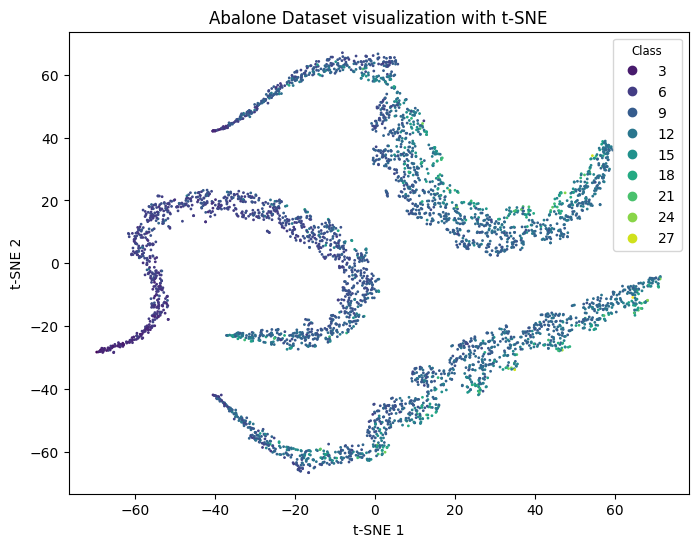

In [18]:
#t-SNE on abalone dataset
abalone_embedding_tsne = TSNE(random_state = 42).fit_transform(X_1)

#Plot t-SNE result
plt.figure(figsize = (8,6))
plt.title("Abalone Dataset visualization with t-SNE")
scatter_plot = plt.scatter(abalone_embedding_tsne[:,0], abalone_embedding_tsne[:,1], c = y_1, s = 1)
plt.legend(*scatter_plot.legend_elements(), title = "Class", title_fontsize = "small")
plt.xlabel("t-SNE 1") #Embedding dimension 0
plt.ylabel("t-SNE 2") #Embedding dimension 1
plt.show()

Abalone PCA

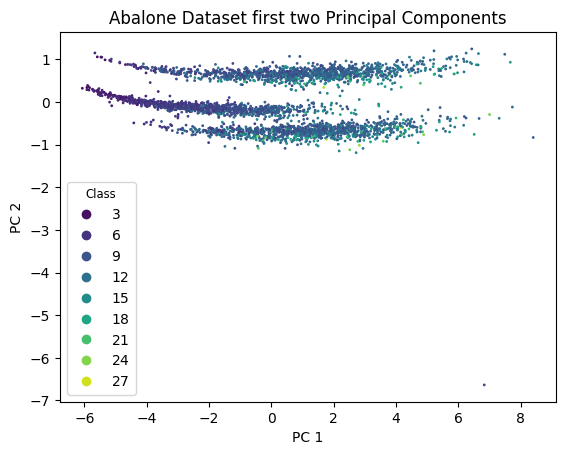

Total variance explained by the principal components:  [6.44054494 0.34705457 0.29589217 0.21486068 0.16847349 0.11585485
 0.06441413 0.01318549 0.00691487 0.        ]
Percentage of variance explained by the principal components:  [0.84001317 0.04526487 0.03859197 0.02802337 0.02197329 0.01511046
 0.00840126 0.00171973 0.00090188 0.        ]


In [19]:
#PCA on the training data
abalone_pca = PCA()
abalone_train_pca_embedding = abalone_pca.fit_transform(X_train2)

plt.title("Abalone Dataset first two Principal Components")
scatter_plot = plt.scatter(abalone_train_pca_embedding[:,0], abalone_train_pca_embedding[:,1], c = y_train2, s = 1)
plt.legend(*scatter_plot.legend_elements(), title = "Class", title_fontsize = "small")
plt.xlabel("PC 1") #Embedding dimension 0
plt.ylabel("PC 2") #Embedding dimension 1
plt.show()

print("Total variance explained by the principal components: ", abalone_pca.explained_variance_)
print("Percentage of variance explained by the principal components: ", abalone_pca.explained_variance_ratio_)

Abalone LDA

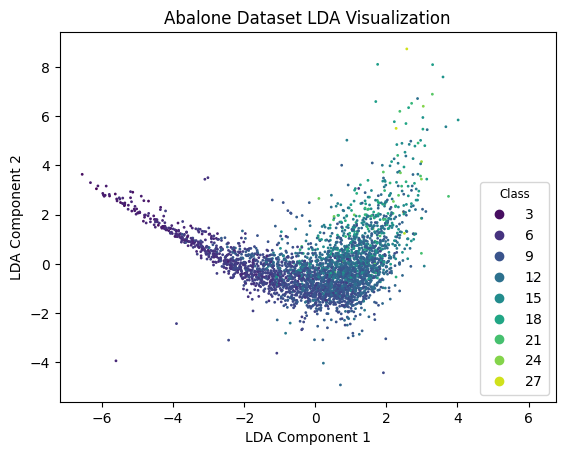

Percentage of variance explained by the components:  [0.70787411 0.22016965 0.04527783 0.01072997 0.00661223 0.00443013
 0.00265417 0.00145777 0.00079413]


In [20]:
abalone_lda = LinearDiscriminantAnalysis()
abalone_train_lda_result = abalone_lda.fit_transform(X_train2, y_train2)

plt.title("Abalone Dataset LDA Visualization")
scatter_plot = plt.scatter(abalone_train_lda_result[:,0], abalone_train_lda_result[:,1], c = y_train2, s = 1)
plt.legend(*scatter_plot.legend_elements(), title = "Class", title_fontsize = "small", loc = "lower right")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.show()

print("Percentage of variance explained by the components: ", abalone_lda.explained_variance_ratio_)

Scree plot

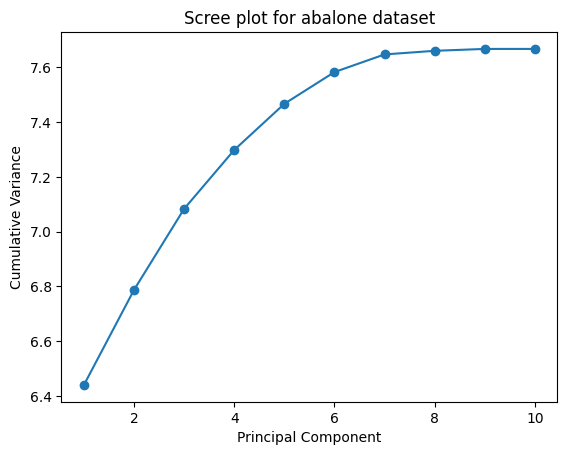

In [21]:
plt.title("Scree plot for abalone dataset")
plt.plot([i for i in range(1, abalone_pca.n_components_+1)], np.cumsum(abalone_pca.explained_variance_), 'o-')
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance")
plt.show()

Rerun the regression experiments on abalone-pca and abalone-lda

In [22]:
#Perform PCA and LDA on train and test data using chosen number of components
reduced_dim_size = 6
selected_PCA = PCA(n_components = reduced_dim_size)
selected_LDA = LinearDiscriminantAnalysis(n_components= reduced_dim_size)

abalone_pca_X_train = selected_PCA.fit_transform(X_train2)
abalone_pca_X_test = selected_PCA.transform(X_test2)

abalone_lda_X_train = selected_LDA.fit_transform(X_train2, y_train2)
abalone_lda_X_test = selected_LDA.transform(X_test2)

In [23]:
#Rerun regression experiments on abalone_pca

#K-Nearest Neighbours Model
#Hyperparameter tuning with grid search
knn_parameters = {"n_neighbors":[i for i in range(1,21)], "weights":["uniform","distance"]}
knn_gridsearch = GridSearchCV(KNeighborsRegressor(), param_grid = knn_parameters, scoring='neg_mean_squared_error', cv = 5)

#Random Forest Model
#Hyperparameter tuning with grid search
rf_parameters = {"n_estimators": [i for i in range(3, 50, 10)] , "max_depth": [j for j in range(2,10)]}
rf_gridsearch = GridSearchCV(RandomForestRegressor(random_state = 42), param_grid = rf_parameters,scoring='neg_mean_squared_error', cv = 5)

#Gradient Tree Boosting Model
#Hyperparameter Tuning:
gtb_parameters = {"n_estimators": [i for i in range(3, 50, 10)] , "max_depth": [j for j in range(2,10)]}
gtb_gridsearch = GridSearchCV(GradientBoostingRegressor(random_state = 42), param_grid = gtb_parameters, scoring='neg_mean_squared_error', cv = 5)

models = [knn_gridsearch, rf_gridsearch, gtb_gridsearch]
for model in models:
    #Fit the training data to the grid search cross validation for each model
    model.fit(X = abalone_pca_X_train, y =  y_train2)

model_names = ["knn", "random_forest", "gradient_tree_boosting"]
abalone_pca_rmse_results = {}

for i, model in enumerate(models):
    #Get the test result using the model with best found parameters
    y_pred = model.predict(X = abalone_pca_X_test)
    rmse_val = root_mean_squared_error(y_true = y_test2, y_pred = y_pred)
    abalone_pca_rmse_results[model_names[i]] = rmse_val

    print("Regression results for model ", model_names[i],": ")
    print("Best parameter combination: ", model.best_params_)
    print("Mean cross validation score of best estimator: ", model.best_score_)
    print("Variance of cross validation test score of best estimator:", (model.cv_results_["std_test_score"][model.best_index_])**2 )
    print("RMSE:", rmse_val,"\n")

Regression results for model  knn : 
Best parameter combination:  {'n_neighbors': 18, 'weights': 'distance'}
Mean cross validation score of best estimator:  -5.054063713862527
Variance of cross validation test score of best estimator: 0.1323137700681947
RMSE: 2.15308047010916 

Regression results for model  random_forest : 
Best parameter combination:  {'max_depth': 6, 'n_estimators': 43}
Mean cross validation score of best estimator:  -4.860370144948147
Variance of cross validation test score of best estimator: 0.11284553473263764
RMSE: 2.067084075994776 

Regression results for model  gradient_tree_boosting : 
Best parameter combination:  {'max_depth': 3, 'n_estimators': 43}
Mean cross validation score of best estimator:  -4.87730119162442
Variance of cross validation test score of best estimator: 0.1123531711393312
RMSE: 2.0827530279075317 



In [24]:
#Rerun regression experiments on abalone-lda

#K-Nearest Neighbours Model
#Hyperparameter tuning with grid search
knn_parameters = {"n_neighbors":[i for i in range(1,21)], "weights":["uniform","distance"]}
knn_gridsearch = GridSearchCV(KNeighborsRegressor(), param_grid = knn_parameters, scoring='neg_mean_squared_error', cv = 5)

#Random Forest Model
#Hyperparameter tuning with grid search
rf_parameters = {"n_estimators": [i for i in range(3, 50, 10)] , "max_depth": [j for j in range(2,10)]}
rf_gridsearch = GridSearchCV(RandomForestRegressor(random_state = 42), param_grid = rf_parameters,scoring='neg_mean_squared_error', cv = 5)

#Gradient Tree Boosting Model
#Hyperparameter Tuning:
gtb_parameters = {"n_estimators": [i for i in range(3, 50, 10)] , "max_depth": [j for j in range(2,10)]}
gtb_gridsearch = GridSearchCV(GradientBoostingRegressor(random_state = 42), param_grid = gtb_parameters, scoring='neg_mean_squared_error', cv = 5)

models = [knn_gridsearch, rf_gridsearch, gtb_gridsearch]
for model in models:
    #Fit the training data to the grid search cross validation for each model
    model.fit(X = abalone_lda_X_train, y = y_train2)

model_names = ["knn", "random_forest", "gradient_tree_boosting"]
abalone_lda_rmse_results = {}

for i, model in enumerate(models):
    #Get the test result using the model with best found parameters
    y_pred = model.predict(X = abalone_lda_X_test)
    rmse_val = root_mean_squared_error(y_true = y_test2, y_pred = y_pred)
    abalone_lda_rmse_results[model_names[i]] = rmse_val

    print("Regression results for model ", model_names[i],": ")
    print("Best parameter combination: ", model.best_params_)
    print("Mean cross validation score of best estimator: ", model.best_score_)
    print("Variance of cross validation test score of best estimator:", (model.cv_results_["std_test_score"][model.best_index_])**2 )
    print("RMSE:", rmse_val,"\n")

Regression results for model  knn : 
Best parameter combination:  {'n_neighbors': 18, 'weights': 'distance'}
Mean cross validation score of best estimator:  -4.444986593901846
Variance of cross validation test score of best estimator: 0.11437642610609496
RMSE: 2.0458713317900776 

Regression results for model  random_forest : 
Best parameter combination:  {'max_depth': 5, 'n_estimators': 33}
Mean cross validation score of best estimator:  -4.453216733011255
Variance of cross validation test score of best estimator: 0.051464238108026104
RMSE: 1.9969925843191 

Regression results for model  gradient_tree_boosting : 
Best parameter combination:  {'max_depth': 3, 'n_estimators': 43}
Mean cross validation score of best estimator:  -4.471294370058796
Variance of cross validation test score of best estimator: 0.07093935201838326
RMSE: 1.9840065289974094 



### Wine Data Representation Learning

In [25]:
#Standardize the data using StandardScaler
scaler = StandardScaler()
wine_X_train_scaled = scaler.fit_transform(wine_X_train)
wine_X_test_scaled = scaler.transform(wine_X_test)

#Renamed for clarity
wine_y_train2 = wine_y_train
wine_y_test2 = wine_y_test

Wine tSNE

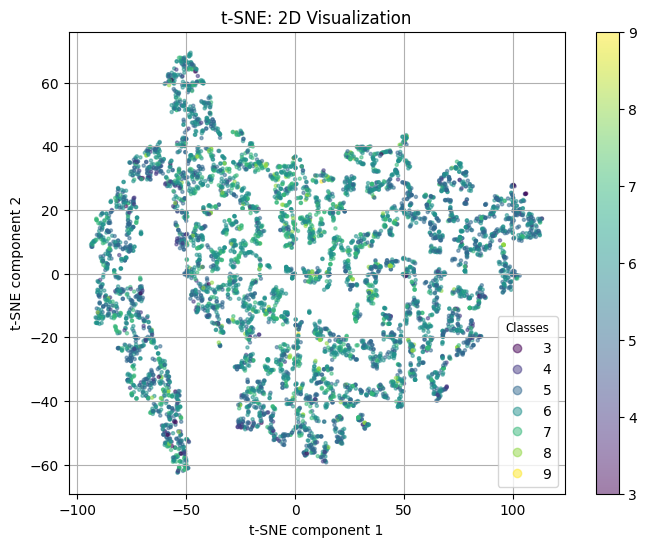

In [26]:
# Apply t-SNE
wine_tsne = TSNE(random_state=42)
X_tsne = wine_tsne.fit_transform(X)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis',  s = 5, alpha=0.5)
# Add legend
plt.legend(*scatter.legend_elements(), title="Classes", title_fontsize = "small")
plt.colorbar()
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.title("t-SNE: 2D Visualization")
plt.grid(True)
plt.show()

Wine PCA

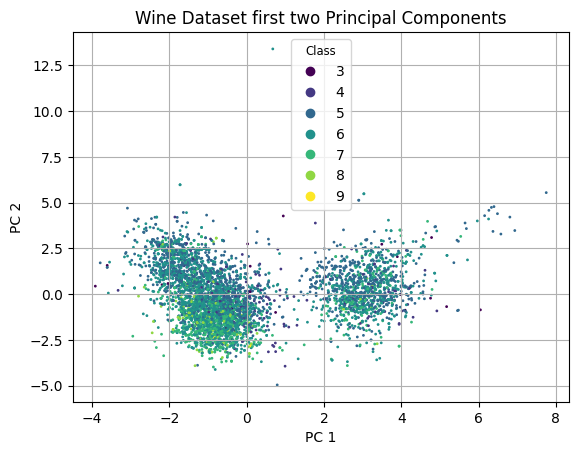

Total variance explained by the principal components:  [3.84055776 2.51834864 1.55665273 0.97096731 0.72307613 0.60471887
 0.54027607 0.4956558  0.35508118 0.25195215 0.11990222 0.02527471]
Percentage of variance explained by the principal components:  [0.31998079 0.20981931 0.12969443 0.08089733 0.06024398 0.0503829
 0.04501376 0.04129617 0.02958402 0.0209917  0.0099898  0.00210579]


In [27]:
#PCA on the training data
wine_pca = PCA()
wine_train_pca = wine_pca.fit_transform(wine_X_train_scaled)

plt.title("Wine Dataset first two Principal Components")
scatter_plot = plt.scatter(wine_train_pca[:,0], wine_train_pca[:,1], c = wine_y_train2, s = 1)
plt.legend(*scatter_plot.legend_elements(), title = "Class", title_fontsize = "small")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid()
plt.show()

print("Total variance explained by the principal components: ", wine_pca.explained_variance_)
print("Percentage of variance explained by the principal components: ", wine_pca.explained_variance_ratio_)

Wine LDA

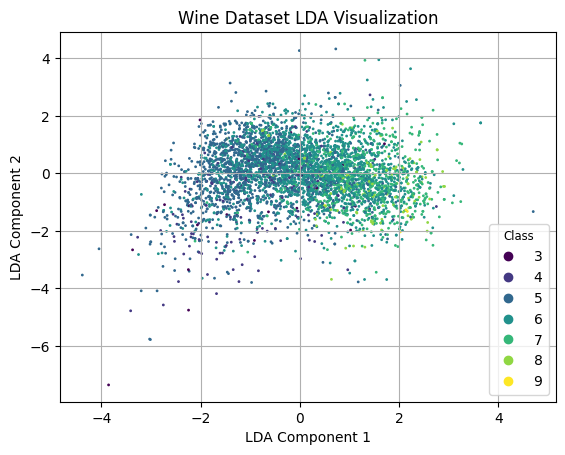

Percentage of variance explained by the components:  [0.8604774  0.09008504 0.02869108 0.0106477  0.00835644 0.00174235]


In [28]:
wine_lda = LinearDiscriminantAnalysis()
wine_train_lda = wine_lda.fit_transform(wine_X_train_scaled, wine_y_train2)

plt.title("Wine Dataset LDA Visualization")
scatter_plot = plt.scatter(wine_train_lda[:,0], wine_train_lda[:,1], c = wine_y_train2, s = 1)
plt.legend(*scatter_plot.legend_elements(), title = "Class", title_fontsize = "small", loc = "lower right")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.grid()
plt.show()

print("Percentage of variance explained by the components: ", wine_lda.explained_variance_ratio_)

Scree Plot

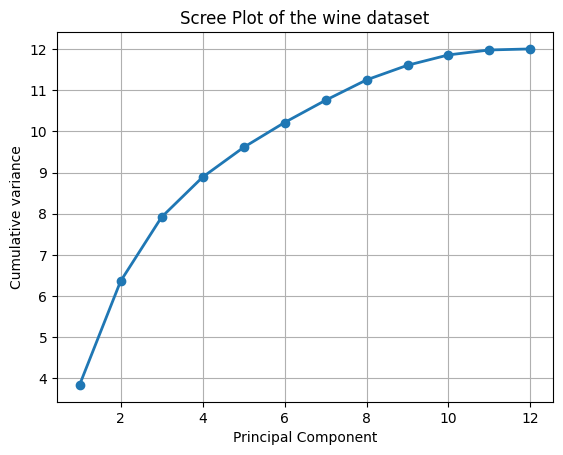

In [29]:
PC_values = np.arange(wine_pca.n_components_) + 1
plt.plot(PC_values, np.cumsum(wine_pca.explained_variance_), 'o-', linewidth=2)
plt.title('Scree Plot of the wine dataset')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative variance')
plt.grid()
plt.show()

Datasets with best reduced dimentionaily and regression rerun

In [30]:
#Perform PCA and LDA on train and test data using chosen number of components
reduced_dim_size = 6
selected_PCA = PCA(n_components = reduced_dim_size)
selected_LDA = LinearDiscriminantAnalysis(n_components= reduced_dim_size)

wine_pca_X_train = selected_PCA.fit_transform(wine_X_train_scaled)
wine_pca_X_test = selected_PCA.transform(wine_X_test_scaled)

wine_lda_X_train = selected_LDA.fit_transform(wine_X_train_scaled, wine_y_train2)
wine_lda_X_test = selected_LDA.transform(wine_X_test_scaled)

In [31]:
#Rerun regression experiments on wine_pca

#Hyperparameter tuning with grid search

knn_parameters = {"n_neighbors":[i for i in range(1,21)], "weights":["uniform","distance"]}
rf_parameters = {"n_estimators": [i for i in range(3, 50, 10)] , "max_depth": [j for j in range(2,10)]}
gtb_parameters = {"n_estimators": [i for i in range(3, 50, 10)] , "max_depth": [j for j in range(2,10)]}

knn_gridsearch = GridSearchCV(KNeighborsRegressor(), param_grid = knn_parameters, scoring='neg_mean_squared_error', cv = 5)
rf_gridsearch = GridSearchCV(RandomForestRegressor(random_state = 42), param_grid = rf_parameters,scoring='neg_mean_squared_error', cv = 5)
gtb_gridsearch = GridSearchCV(GradientBoostingRegressor(random_state = 42), param_grid = gtb_parameters, scoring='neg_mean_squared_error', cv = 5)


models = [knn_gridsearch, rf_gridsearch, gtb_gridsearch]
for model in models:
    #Fit the training data to the grid search cross validation for each model
    model.fit(X = wine_pca_X_train, y =  wine_y_train2)

model_names = ["knn", "random_forest", "gradient_tree_boosting"]
wine_pca_rmse_results = {}

for i, model in enumerate(models):
    #Get the test result using the model with best found parameters
    y_pred = model.predict(X = wine_pca_X_test)
    rmse_val = root_mean_squared_error(y_true = wine_y_test2, y_pred = y_pred)
    wine_pca_rmse_results[model_names[i]] = rmse_val

    print("Regression results for model ", model_names[i],": ")
    print("Best parameter combination: ", model.best_params_)
    print("Mean cross validation score of best estimator: ", model.best_score_)
    print("Variance of cross validation test score of best estimator:", (model.cv_results_["std_test_score"][model.best_index_])**2 )
    print("RMSE:", rmse_val,"\n")

Regression results for model  knn : 
Best parameter combination:  {'n_neighbors': 20, 'weights': 'distance'}
Mean cross validation score of best estimator:  -0.41699852548392996
Variance of cross validation test score of best estimator: 4.948346192071579e-05
RMSE: 0.6200766846679363 

Regression results for model  random_forest : 
Best parameter combination:  {'max_depth': 9, 'n_estimators': 43}
Mean cross validation score of best estimator:  -0.481148371713357
Variance of cross validation test score of best estimator: 3.905645287043457e-05
RMSE: 0.6741262347902803 

Regression results for model  gradient_tree_boosting : 
Best parameter combination:  {'max_depth': 9, 'n_estimators': 43}
Mean cross validation score of best estimator:  -0.46243125628752735
Variance of cross validation test score of best estimator: 9.033209733039166e-05
RMSE: 0.6476548942074944 



In [32]:
#Rerun regression experiments on wine_lda
#Hyperparameter tuning with grid search

knn_parameters = {"n_neighbors":[i for i in range(1,21)], "weights":["uniform","distance"]}
rf_parameters = {"n_estimators": [i for i in range(3, 50, 10)] , "max_depth": [j for j in range(2,10)]}
gtb_parameters = {"n_estimators": [i for i in range(3, 50, 10)] , "max_depth": [j for j in range(2,10)]}

knn_gridsearch = GridSearchCV(KNeighborsRegressor(), param_grid = knn_parameters, scoring='neg_mean_squared_error', cv = 5)
rf_gridsearch = GridSearchCV(RandomForestRegressor(random_state = 42), param_grid = rf_parameters,scoring='neg_mean_squared_error', cv = 5)
gtb_gridsearch = GridSearchCV(GradientBoostingRegressor(random_state = 42), param_grid = gtb_parameters, scoring='neg_mean_squared_error', cv = 5)


models = [knn_gridsearch, rf_gridsearch, gtb_gridsearch]
for model in models:
    #Fit the training data to the grid search cross validation for each model
    model.fit(X = wine_lda_X_train, y =  wine_y_train2)

model_names = ["knn", "random_forest", "gradient_tree_boosting"]
wine_lda_rmse_results = {}

for i, model in enumerate(models):
    #Get the test result using the model with best found parameters
    y_pred = model.predict(X = wine_lda_X_test)
    rmse_val = root_mean_squared_error(y_true = wine_y_test2, y_pred = y_pred)
    wine_lda_rmse_results[model_names[i]] = rmse_val

    print("Regression results for model ", model_names[i],": ")
    print("Best parameter combination: ", model.best_params_)
    print("Mean cross validation score of best estimator: ", model.best_score_)
    print("Variance of cross validation test score of best estimator:", (model.cv_results_["std_test_score"][model.best_index_])**2 )
    print("RMSE:", rmse_val,"\n")

Regression results for model  knn : 
Best parameter combination:  {'n_neighbors': 20, 'weights': 'distance'}
Mean cross validation score of best estimator:  -0.40599554423219486
Variance of cross validation test score of best estimator: 0.00021892167003283224
RMSE: 0.6147071781279656 

Regression results for model  random_forest : 
Best parameter combination:  {'max_depth': 9, 'n_estimators': 43}
Mean cross validation score of best estimator:  -0.4665400734150154
Variance of cross validation test score of best estimator: 0.00020563433791466105
RMSE: 0.6633454038274891 

Regression results for model  gradient_tree_boosting : 
Best parameter combination:  {'max_depth': 9, 'n_estimators': 43}
Mean cross validation score of best estimator:  -0.4512294552843759
Variance of cross validation test score of best estimator: 0.00035386277975018546
RMSE: 0.6570627371919764 



Forest Fires Dataset Representation Learning

In [33]:
#Standardize the data using StandardScaler
scaler = StandardScaler()
forestfire_X_train_scaled = scaler.fit_transform(forestfire_X_train)
forestfire_X_test_scaled = scaler.transform(forestfire_X_test)

#Rename and divided into bins for clarity
forestfire_y_train2 = pd.cut(forestfire_y_train, bins=3, labels=[0, 1, 2])
forestfire_y_test2 = pd.cut(forestfire_y_test, bins=3, labels=[0, 1, 2])

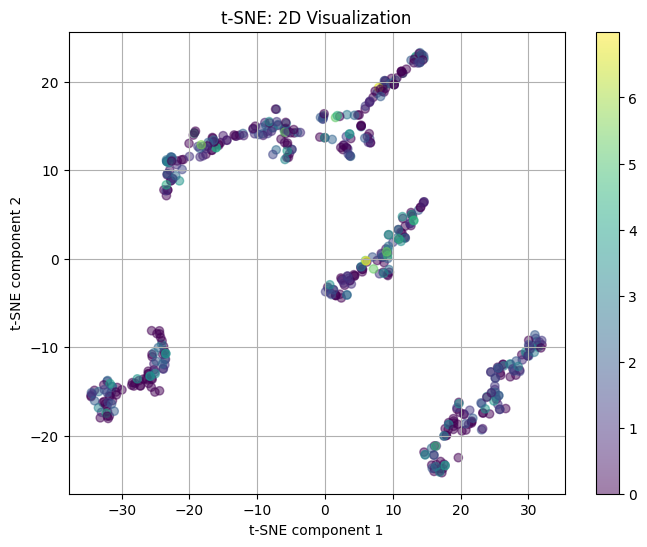

In [34]:
# Apply t-SNE
forestfire_tsne = TSNE(random_state=42)
X_tsne = forestfire_tsne.fit_transform(forestfire_X)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=forestfire_y, cmap='viridis', alpha=0.5)
# Add legend
# plt.legend(*scatter.legend_elements(), title="Classes", title_fontsize = "small")
plt.colorbar()
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.title("t-SNE: 2D Visualization")
plt.grid(True)
plt.show()

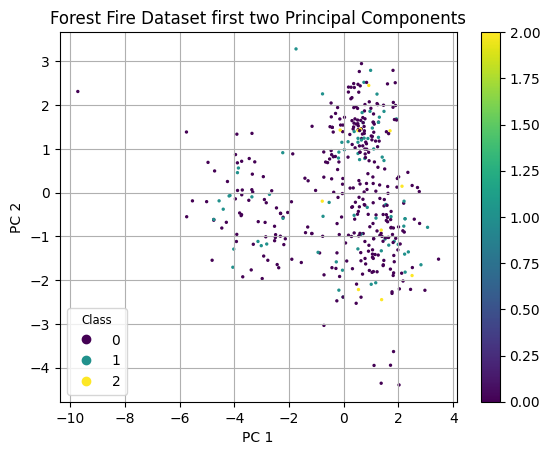

Total variance explained by the principal components:  [3.84751303e+00 1.96417249e+00 1.78187791e+00 1.60982444e+00
 1.55219719e+00 1.29929419e+00 1.27615450e+00 1.26276713e+00
 1.18168708e+00 1.15806054e+00 1.12673054e+00 1.09721276e+00
 1.06715705e+00 1.02532380e+00 1.00589527e+00 9.75792775e-01
 9.37864283e-01 8.75393469e-01 8.39938832e-01 7.83782810e-01
 6.79056785e-01 6.02735176e-01 4.25554128e-01 3.02645942e-01
 2.44216880e-01 1.31092894e-01 1.64464533e-02 1.66099773e-15
 2.23496625e-17]
Percentage of variance explained by the principal components:  [1.32351621e-01 6.75660906e-02 6.12952909e-02 5.53767781e-02
 5.33944428e-02 4.46947655e-02 4.38987771e-02 4.34382613e-02
 4.06491674e-02 3.98364318e-02 3.87587027e-02 3.77433127e-02
 3.67094184e-02 3.52703853e-02 3.46020582e-02 3.35665545e-02
 3.22618423e-02 3.01128922e-02 2.88932787e-02 2.69615528e-02
 2.33590545e-02 2.07336472e-02 1.46387493e-02 1.04107980e-02
 8.40088124e-03 4.50949925e-03 5.65745909e-04 5.71371014e-17
 7.68811968

In [35]:
#PCA on the training data
forestfire_pca = PCA()
forestfire_train_pca = forestfire_pca.fit_transform(forestfire_X_train_scaled)

plt.title("Forest Fire Dataset first two Principal Components")
scatter_plot = plt.scatter(forestfire_train_pca[:,0], forestfire_train_pca[:,1], c = forestfire_y_train2, s = 2)
plt.legend(*scatter_plot.legend_elements(), title = "Class", title_fontsize = "small")
plt.colorbar()
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid()
plt.show()

print("Total variance explained by the principal components: ", forestfire_pca.explained_variance_)
print("Percentage of variance explained by the principal components: ", forestfire_pca.explained_variance_ratio_)

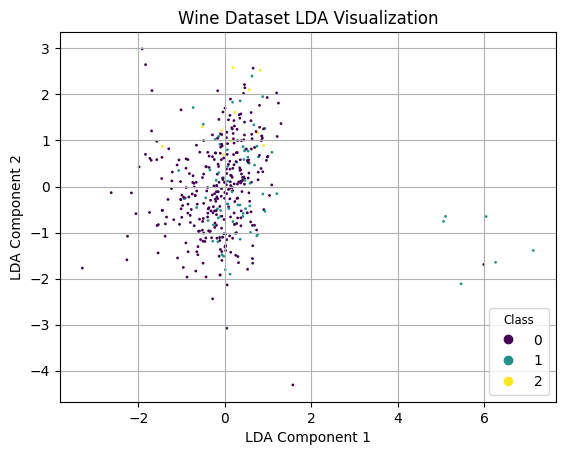

Percentage of variance explained by the components:  [0.63365697 0.36634303]


In [36]:
forestfire_lda = LinearDiscriminantAnalysis()
forestfire_train_lda = forestfire_lda.fit_transform(forestfire_X_train_scaled, forestfire_y_train2)

plt.title("Wine Dataset LDA Visualization")
scatter_plot = plt.scatter(forestfire_train_lda[:,0], forestfire_train_lda[:,1], c = forestfire_y_train2, s = 1)
plt.legend(*scatter_plot.legend_elements(), title = "Class", title_fontsize = "small", loc = "lower right")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.grid()
plt.show()

print("Percentage of variance explained by the components: ", forestfire_lda.explained_variance_ratio_)


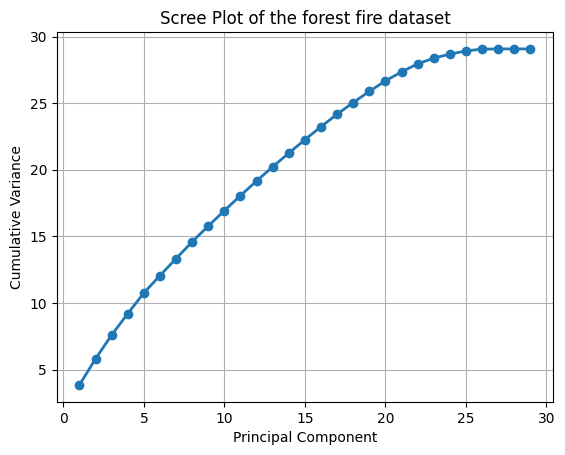

In [37]:
PC_values = np.arange(forestfire_pca.n_components_) + 1
plt.plot(PC_values, np.cumsum(forestfire_pca.explained_variance_), 'o-', linewidth=2)
plt.title('Scree Plot of the forest fire dataset')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance')
plt.grid()
plt.show()

Datasets with best reduced dimentionaily and regression rerun

In [38]:
#Perform PCA and LDA on train and test data using chosen number of components
reduced_dim_size = 2
selected_PCA = PCA(n_components = reduced_dim_size)
selected_LDA = LinearDiscriminantAnalysis(n_components= reduced_dim_size)

forestfire_pca_X_train = selected_PCA.fit_transform(forestfire_X_train_scaled)
forestfire_pca_X_test = selected_PCA.transform(forestfire_X_test_scaled)

forestfire_lda_X_train = selected_LDA.fit_transform(forestfire_X_train_scaled, forestfire_y_train2)
forestfire_lda_X_test = selected_LDA.transform(forestfire_X_test_scaled)

In [39]:
#Rerun regression experiments on forestfire_pca

#Hyperparameter tuning with grid search

knn_parameters = {"n_neighbors":[i for i in range(1,21)], "weights":["uniform","distance"]}
rf_parameters = {"n_estimators": [i for i in range(3, 50, 10)] , "max_depth": [j for j in range(2,10)]}
gtb_parameters = {"n_estimators": [i for i in range(3, 50, 10)] , "max_depth": [j for j in range(2,10)]}

knn_gridsearch = GridSearchCV(KNeighborsRegressor(), param_grid = knn_parameters, scoring='neg_mean_squared_error', cv = 5)
rf_gridsearch = GridSearchCV(RandomForestRegressor(random_state = 42), param_grid = rf_parameters,scoring='neg_mean_squared_error', cv = 5)
gtb_gridsearch = GridSearchCV(GradientBoostingRegressor(random_state = 42), param_grid = gtb_parameters, scoring='neg_mean_squared_error', cv = 5)


models = [knn_gridsearch, rf_gridsearch, gtb_gridsearch]
for model in models:
    #Fit the training data to the grid search cross validation for each model
    model.fit(X = forestfire_pca_X_train, y =  forestfire_y_train2)

model_names = ["knn", "random_forest", "gradient_tree_boosting"]
forestfire_pca_rmse_results = {}

for i, model in enumerate(models):
    #Get the test result using the model with best found parameters
    y_pred = model.predict(X = forestfire_pca_X_test)
    rmse_val = root_mean_squared_error(y_true = forestfire_y_test2, y_pred = y_pred)
    forestfire_pca_rmse_results[model_names[i]] = rmse_val

    print("Regression results for model ", model_names[i],": ")
    print("Best parameter combination: ", model.best_params_)
    print("Mean cross validation score of best estimator: ", model.best_score_)
    print("Variance of cross validation test score of best estimator:", (model.cv_results_["std_test_score"][model.best_index_])**2 )
    print("RMSE:", rmse_val,"\n")

Regression results for model  knn : 
Best parameter combination:  {'n_neighbors': 19, 'weights': 'uniform'}
Mean cross validation score of best estimator:  -0.24806700621823827
Variance of cross validation test score of best estimator: 0.005964359343387066
RMSE: 0.4684824596969262 

Regression results for model  random_forest : 
Best parameter combination:  {'max_depth': 2, 'n_estimators': 33}
Mean cross validation score of best estimator:  -0.2427565252555139
Variance of cross validation test score of best estimator: 0.006970097208175838
RMSE: 0.46218046930990525 

Regression results for model  gradient_tree_boosting : 
Best parameter combination:  {'max_depth': 2, 'n_estimators': 3}
Mean cross validation score of best estimator:  -0.24122389844679187
Variance of cross validation test score of best estimator: 0.005757851675016348
RMSE: 0.4643121171253783 



In [40]:
#Rerun regression experiments on wine_pca

#Hyperparameter tuning with grid search

knn_parameters = {"n_neighbors":[i for i in range(1,21)], "weights":["uniform","distance"]}
rf_parameters = {"n_estimators": [i for i in range(3, 50, 10)] , "max_depth": [j for j in range(2,10)]}
gtb_parameters = {"n_estimators": [i for i in range(3, 50, 10)] , "max_depth": [j for j in range(2,10)]}

knn_gridsearch = GridSearchCV(KNeighborsRegressor(), param_grid = knn_parameters, scoring='neg_mean_squared_error', cv = 5)
rf_gridsearch = GridSearchCV(RandomForestRegressor(random_state = 42), param_grid = rf_parameters,scoring='neg_mean_squared_error', cv = 5)
gtb_gridsearch = GridSearchCV(GradientBoostingRegressor(random_state = 42), param_grid = gtb_parameters, scoring='neg_mean_squared_error', cv = 5)


models = [knn_gridsearch, rf_gridsearch, gtb_gridsearch]
for model in models:
    #Fit the training data to the grid search cross validation for each model
    model.fit(X = forestfire_lda_X_train, y =  forestfire_y_train2)

model_names = ["knn", "random_forest", "gradient_tree_boosting"]
forestfire_lda_rmse_results = {}

for i, model in enumerate(models):
    #Get the test result using the model with best found parameters
    y_pred = model.predict(X = forestfire_lda_X_test)
    rmse_val = root_mean_squared_error(y_true = forestfire_y_test2, y_pred = y_pred)
    forestfire_lda_rmse_results[model_names[i]] = rmse_val

    print("Regression results for model ", model_names[i],": ")
    print("Best parameter combination: ", model.best_params_)
    print("Mean cross validation score of best estimator: ", model.best_score_)
    print("Variance of cross validation test score of best estimator:", (model.cv_results_["std_test_score"][model.best_index_])**2 )
    print("RMSE:", rmse_val,"\n")

Regression results for model  knn : 
Best parameter combination:  {'n_neighbors': 17, 'weights': 'uniform'}
Mean cross validation score of best estimator:  -0.23647870238655694
Variance of cross validation test score of best estimator: 0.007836013573369483
RMSE: 0.46693291896354655 

Regression results for model  random_forest : 
Best parameter combination:  {'max_depth': 2, 'n_estimators': 43}
Mean cross validation score of best estimator:  -0.23612667352690972
Variance of cross validation test score of best estimator: 0.005620999453103697
RMSE: 0.45611289988730835 

Regression results for model  gradient_tree_boosting : 
Best parameter combination:  {'max_depth': 2, 'n_estimators': 3}
Mean cross validation score of best estimator:  -0.23481814940235535
Variance of cross validation test score of best estimator: 0.00588152623656809
RMSE: 0.4584490979951522 



# Results Table

In [41]:
results_dict = {"Dataset": ["wine", "wine-pca,","wine-lda","abalone", "abalone-pca","abalone-lda","forest-fires","forest-fires-pca","forest-fires-lda"],
                "k-NN RMSE result":[wine_rmse_results["knn"], wine_pca_rmse_results["knn"], wine_lda_rmse_results["knn"],
                                    abalone_rmse_results["knn"], abalone_pca_rmse_results["knn"], abalone_lda_rmse_results["knn"],
                                    forestfire_rmse_results["knn"],forestfire_pca_rmse_results["knn"],forestfire_lda_rmse_results["knn"]],
                "Random Forest RMSE result":[wine_rmse_results["random_forest"], wine_pca_rmse_results["random_forest"], wine_lda_rmse_results["random_forest"],
                                             abalone_rmse_results["random_forest"], abalone_pca_rmse_results["random_forest"] ,abalone_lda_rmse_results["random_forest"],
                                             forestfire_rmse_results["random_forest"],forestfire_pca_rmse_results["random_forest"],forestfire_lda_rmse_results["random_forest"]],
                "Gradient Tree Boosting RMSE result":[wine_rmse_results["gradient_tree_boosting"], wine_pca_rmse_results["gradient_tree_boosting"], wine_lda_rmse_results["gradient_tree_boosting"],
                                                      abalone_rmse_results["gradient_tree_boosting"], abalone_pca_rmse_results["gradient_tree_boosting"],abalone_lda_rmse_results["gradient_tree_boosting"],
                                                      forestfire_rmse_results["gradient_tree_boosting"],forestfire_pca_rmse_results["gradient_tree_boosting"],forestfire_lda_rmse_results["gradient_tree_boosting"]]}
results_df = pd.DataFrame.from_dict(results_dict)
results_df

,Dataset,k-NN RMSE result,Random Forest RMSE result,Gradient Tree Boosting RMSE result
0,wine,0.610445,0.660339,0.630766
1,"wine-pca,",0.620077,0.674126,0.647655
2,wine-lda,0.614707,0.663345,0.657063
3,abalone,2.104299,2.056634,2.093830
4,abalone-pca,2.153080,2.067084,2.082753
5,abalone-lda,2.045871,1.996993,1.984007
6,forest-fires,1.501907,1.499944,1.472814
7,forest-fires-pca,0.468482,0.462180,0.464312
8,forest-fires-lda,0.466933,0.456113,0.458449


# References

[1] “Column Transformer with Mixed Types,” scikit-learn, https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html (accessed Mar. 1, 2025).
